In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import seaborn as sns
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import f1_score


In [2]:
### CLEANING DATA

###EPITOME
epitome = pd.read_csv("original_samples/sample_epitome.csv")
epitome = epitome[
    [
        "sp_id",
        "rp_id",
        "level_emotional_reactions",
        "level_explorations",
        "level_interpretations",
    ]
]
epitome.to_csv("data/epitome/sample_ratings_crowdsourced.csv", index=False)

###PERCEIVED EMPATHY
perceived_empathy = pd.read_csv(
    "original_samples/sample_perceived_empathy_annotations.csv"
)
perceived_empathy = perceived_empathy.rename(columns={"OriginalDiscloserID": "id"})
perceived_empathy = perceived_empathy[
    [
        "id",
        "m_understood",
        "m_validated",
        "m_affirmed",
        "m_seen",
        "m_accepted",
        "m_caredfor",
        "m_emotional",
        "m_practical",
        "m_motivation",
    ]
]
perceived_empathy.to_csv(
    "data/perceived_empathy/sample_ratings_crowdsourced.csv", index=False
)

###EMPATHETIC DIALOGUES
empathetic_dialogues = pd.read_csv("original_samples/sample_empatheticdialogues.csv")
empathetic_dialogues = empathetic_dialogues.drop_duplicates(subset=["conv_id"])
empathetic_dialogues["empathy"] = empathetic_dialogues[["empathy1", "empathy2"]].mean(
    axis=1
)
empathetic_dialogues["fluency"] = empathetic_dialogues[["fluency1", "fluency2"]].mean(
    axis=1
)
empathetic_dialogues["relevance"] = empathetic_dialogues[
    ["relevance1", "relevance2"]
].mean(axis=1)
empathetic_dialogues = empathetic_dialogues[
    ["conv_id", "empathy", "fluency", "relevance"]
]
empathetic_dialogues.to_csv(
    "data/empatheticdialogues/sample_ratings_crowdsourced.csv", index=False
)

# ###RPG
rpg = pd.read_csv("original_samples/sample_rpg_annotations.csv")
rpg = rpg.drop(
    columns=[
        "user_id",
        "id",
        "validating_emotions_example",
        "encouraging_elaboration_example",
        "demonstrating_understanding_example",
        "self_oriented_example",
        "advice_giving_example",
        "dismissing_emotions_example",
        "time_created",
    ]
)
rpg_mean = rpg.groupby("conversation_id").mean().reset_index()
rpg_mean.to_csv("data/rpg/sample_ratings_crowdsourced.csv", index=False)

In [3]:
# List of base files containing ratings and annotations from different sources
base_files = [
    "expert_ratings.csv",  # Ratings from the first expert
    "expert2_ratings.csv",  # Ratings from the second expert
    "llm_annotations/llm_bruce_wisdom_user_prompt.csv",  # Annotations from GPT4
    "llm_annotations/llm_bruce_wisdom_user_prompt_gemini.csv",  # Annotations from Gemini
    "sample_ratings_crowdsourced.csv",  # Crowdsourced ratings
]

# Dictionary defining datasets with their respective file paths, sort columns, and dimensions
datasets = {
    "rpg": {
        "files": [
            f"data/rpg/{file}" for file in base_files
        ],  # File paths for RPG dataset
        "sort_column": "conversation_id",
        "dimensions": [
            "validating_emotions",
            "encouraging_elaboration",
            "demonstrating_understanding",
            "advice_giving",
            "self_oriented",
            "dismissing_emotions",
        ],  # Dimensions for RPG dataset
    },
    "perceived_empathy": {
        "files": [
            f"data/perceived_empathy/{file}" for file in base_files
        ],  # File paths for Perceived Empathy dataset
        "sort_column": "id",
        "dimensions": [
            "m_understood",
            "m_validated",
            "m_affirmed",
            "m_seen",
            "m_accepted",
            "m_caredfor",
            "m_emotional",
            "m_practical",
            "m_motivation",
        ],  # Dimensions for Perceived Empathy dataset
    },
    "empatheticdialogues": {
        "files": [
            f"data/empatheticdialogues/{file}" for file in base_files
        ],  # File paths for Empathetic Dialogues dataset
        "sort_column": "conv_id",
        "dimensions": [
            "empathy",
            "relevance",
            "fluency",
        ],  # Dimensions for Empathetic Dialogues dataset
    },
    "epitome": {
        "files": [
            f"data/epitome/{file}" for file in base_files
        ],  # File paths for Epitome dataset
        "sort_column": "sp_id",
        "dimensions": [
            "level_emotional_reactions",
            "level_explorations",
            "level_interpretations",
        ],  # Dimensions for Epitome dataset
    },
}

In [4]:
###COMBINING ANNOTATION DATA FROM ALL DATASETS
def order_by_column(df, column):
    return df.sort_values(by=column).reset_index(drop=True)


def load_and_process(filepath, sort_column):
    df = pd.read_csv(filepath)
    return order_by_column(df, sort_column)


data = {}
# List of annotation methods corresponding to the files in each dataset
annotation_methods = ["expert1", "expert2", "llm", "gemini", "crowd"]

for key in datasets.keys():
    for i in range(len(datasets[key]["files"])):
        data[key, annotation_methods[i]] = load_and_process(
            datasets[key]["files"][i], datasets[key]["sort_column"]
        )
        data[key, annotation_methods[i]]["annotation_method"] = annotation_methods[i]

mean_expert_ratings = {}

for key in datasets.keys():
    expert1_df = data[key, "expert1"]
    expert2_df = data[key, "expert2"]
    mean_df = expert1_df.copy()
    # Calculate the mean for each dimension
    for dimension in datasets[key]["dimensions"]:
        mean_df[dimension] = (expert1_df[dimension] + expert2_df[dimension]) / 2
    mean_expert_ratings[key] = mean_df

# Add the 'experts' method to the data dictionary, using the mean of expert1 and expert2
for key in datasets.keys():
    mean_expert_df = mean_expert_ratings[key]
    # Set the annotation method to 'experts'
    mean_expert_df["annotation_method"] = "experts"
    data[key, "experts"] = mean_expert_df

data_combined = {}


# Concatenate data for all annotation methods within each dataset
for key in datasets.keys():
    data_combined[key] = pd.concat(
        data[key, annotation_methods[i]] for i in range(len(annotation_methods))
    )


# Add the 'experts' data to the combined data for each dataset
for key in datasets.keys():
    data_combined[key] = pd.concat([data_combined[key], data[key, "experts"]])


# Combine all datasets into a single DataFrame by concatenating along the columns
data_combined_all = pd.concat((data_combined[key] for key in datasets.keys()), axis=1)


# Rename columns to include dataset-specific identifiers
data_combined_all.rename(
    columns={
        "conv_id": "empathetic_conversation_id",
        "sp_id": "epitome_conversation_id",
        "id": "perceived_conversation_id",
        "conversation_id": "rpg_conversation_id",
    },
    inplace=True,
)

# Save the combined DataFrame to a CSV file
data_combined_all.to_csv(
    "data/combined_annotations_across_methods_and_datasets.csv", index=False
)


In [5]:
# CALCULAtING SPEARMAN CORRELATION AND WEIGHTED COHEN'S KAPPA BETWEEN DIFFERENT ANNOTATION METHODS FOR EACH DATASET

df = pd.read_csv("data/combined_annotations_across_methods_and_datasets.csv")

# Define the pairs of annotators to compare
annotator_pairs = [
    ("experts", "llm"),
    ("experts", "crowd"),
    ("llm", "crowd"),
    ("expert1", "expert2"),
    ("experts", "gemini"),
    ("gemini", "crowd"),
]

# Initialize a dictionary to store the results of the analysis
results = {
    "Dataset": [],  # Name of the dataset
    "Dimension": [],  # Dimension being analyzed
    "Annotator Pair": [],  # Pair of annotators being compared
    "Spearman Correlation": [],  # Spearman correlation value
    "Spearman P-value": [],  # P-value for the Spearman correlation
    "Fisher CI Lower": [],  # Lower bound of Fisher confidence interval
    "Fisher CI Upper": [],  # Upper bound of Fisher confidence interval
    "Weighted Cohen's Kappa": [],  # Weighted Cohen's Kappa value
}


# Function to determine the dataset name based on the dimension
def get_dataset_name(dimension):
    if dimension in datasets["empatheticdialogues"]["dimensions"]:
        return "Empathetic Dialogues"
    elif dimension in datasets["epitome"]["dimensions"]:
        return "EPITOME"
    elif dimension in datasets["perceived_empathy"]["dimensions"]:
        return "Perceived Empathy"
    elif dimension in datasets["rpg"]["dimensions"]:
        return "RPG"


# Function to calculate pairwise correlations and other statistics for given annotator pairs
def calculate_pairwise_correlations(df, dimensions, pair_name):
    for dimension in dimensions:
        # Extract data for each annotation method in the pair
        series1 = df[df["annotation_method"] == pair_name[0]][dimension].reset_index(
            drop=True
        )
        series2 = df[df["annotation_method"] == pair_name[1]][dimension].reset_index(
            drop=True
        )

        # Ensure both series have the same length
        min_len = min(len(series1), len(series2))
        series1 = series1[:min_len]
        series2 = series2[:min_len]

        corr_value, p_value = spearmanr(series1, series2)  # Spearman correlation
        fisher_ci_lower, fisher_ci_upper = calculate_fisher_ci(
            corr_value, len(series1)
        )  # Fisher CI
        # Calculate Cohen's Kappa, multiplying by 100 to get integer values
        kappa_value = cohen_kappa_score(
            np.round(series1 * 100), np.round(series2 * 100), weights="quadratic"
        )

        # Store the calculated results
        results["Dataset"].append(get_dataset_name(dimension))
        results["Dimension"].append(dimension)
        results["Annotator Pair"].append(pair_name)
        results["Spearman Correlation"].append(corr_value)
        results["Spearman P-value"].append(p_value)
        results["Fisher CI Lower"].append(fisher_ci_lower)
        results["Fisher CI Upper"].append(fisher_ci_upper)
        results["Weighted Cohen's Kappa"].append(kappa_value)


# Function to calculate Fisher confidence interval for correlation
def calculate_fisher_ci(r, n):
    if n <= 3:
        return np.nan, np.nan  # Avoid division by zero or negative square root
    z = np.arctanh(r)  # Fisher transformation
    se = 1 / np.sqrt(n - 3)  # Standard error
    ci_lower = np.tanh(z - 1.96 * se)
    ci_upper = np.tanh(z + 1.96 * se)
    return ci_lower, ci_upper


# Define the dimensions for each dataset category
dimensions = (
    datasets["empatheticdialogues"]["dimensions"]
    + datasets["epitome"]["dimensions"]
    + datasets["perceived_empathy"]["dimensions"]
    + datasets["rpg"]["dimensions"]
)

# Calculate correlations for each pair of annotators
for pair in annotator_pairs:
    calculate_pairwise_correlations(df, dimensions, pair)

# Create a DataFrame from the results dictionary
results_df = pd.DataFrame(results)

# Format the DataFrame to show only two or three decimal places as appropriate
results_df["Spearman Correlation"] = results_df["Spearman Correlation"].apply(
    lambda x: f"{x:.2f}"
)
results_df["Weighted Cohen's Kappa"] = results_df["Weighted Cohen's Kappa"].apply(
    lambda x: f"{x:.2f}"
)
results_df["Spearman P-value"] = results_df["Spearman P-value"].apply(
    lambda x: f"{x:.3f}"
)
results_df["Fisher CI Lower"] = results_df["Fisher CI Lower"].apply(
    lambda x: f"{x:.2f}"
)
results_df["Fisher CI Upper"] = results_df["Fisher CI Upper"].apply(
    lambda x: f"{x:.2f}"
)
results_df["Annotator Pair"] = results_df["Annotator Pair"].astype(str)

results_df = results_df.sort_values(
    by=["Annotator Pair", "Dimension"], ignore_index=True
)

# Save the results to a CSV file
results_df.to_csv("data/all_annotator_pairs_spearman_kappa.csv", index=False)

In [6]:
### REPLICATING TABLE 3 FROM THE PAPER
table_3 = results_df[
    (results_df["Annotator Pair"] != "('experts', 'gemini')")
    & (results_df["Annotator Pair"] != "('gemini', 'crowd')")
][
    [
        "Dataset",
        "Dimension",
        "Annotator Pair",
        "Spearman Correlation",
        "Spearman P-value",
    ]
]

table_3.to_csv("data/table_3.csv", index=False)


In [7]:
### REPLICATING TABLE 4 (APPENDIX TABLE 1) FROM THE PAPER
table_4 = results_df[
    (results_df["Annotator Pair"] != "('experts', 'llm')")
    & (results_df["Annotator Pair"] != "('llm', 'crowd')")
][
    [
        "Dataset",
        "Dimension",
        "Annotator Pair",
        "Spearman Correlation",
        "Spearman P-value",
    ]
]

table_4.to_csv("data/table_4.csv", index=False)




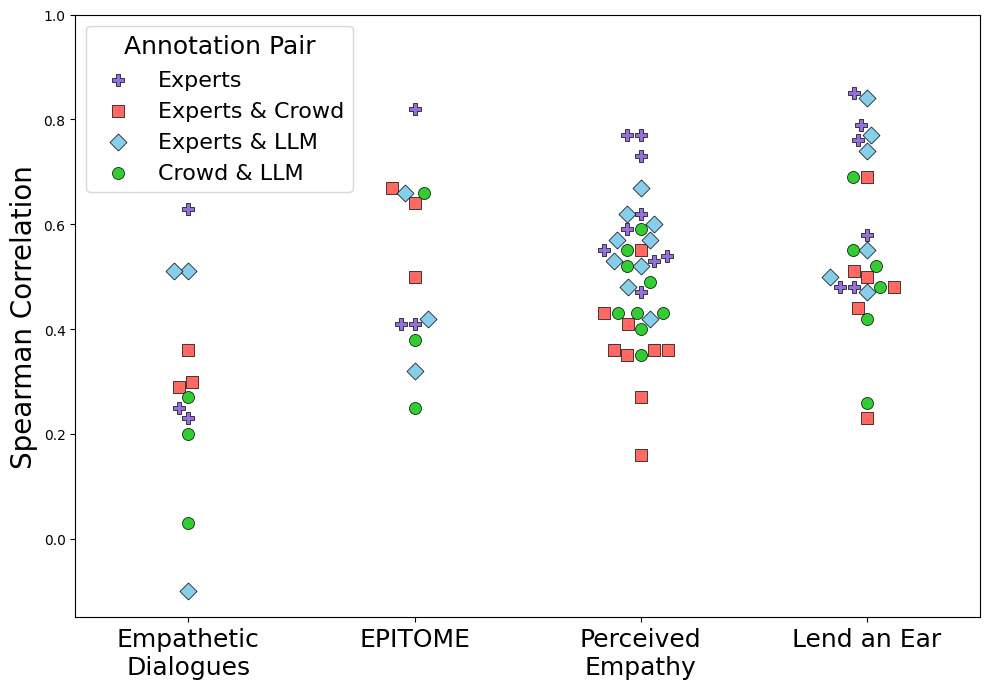

In [8]:
# Clean up the Annotator Pair labels first
label_mapping = {
    "('expert1', 'expert2')": "Experts",
    "('experts', 'crowd')": "Experts & Crowd",
    "('experts', 'llm')": "Experts & LLM",
    "('llm', 'crowd')": "Crowd & LLM",
}

# Create a clean copy of the data with fixed labels
plot_data = table_3.copy()
plot_data["Annotator Pair"] = plot_data["Annotator Pair"].replace(label_mapping)
plot_data["Spearman Correlation"] = plot_data["Spearman Correlation"].astype(float)

# Define marker mapping and colors
marker_mapping = {
    "Experts": "P",           # plus filled
    "Experts & Crowd": "s",   # square 
    "Experts & LLM": "D",     # diamond
    "Crowd & LLM": "o",       # circle
}

colors = {
    "Experts": "#9370DB",         # Purple
    "Experts & Crowd": "#FF6961", # Red
    "Experts & LLM": "#87CEEB",   # Light Blue
    "Crowd & LLM": "#32CD32"      # Green
}

hue_order = ["Experts", "Experts & Crowd", "Experts & LLM", "Crowd & LLM"]
dataset_order = ["Empathetic Dialogues", "EPITOME", "Perceived Empathy", "RPG"]

plt.figure(figsize=(10, 7))
ax = sns.swarmplot(
    data=plot_data,
    x="Dataset",
    y="Spearman Correlation",
    hue="Annotator Pair",
    hue_order=hue_order,
    order=dataset_order,
    palette=colors,
    size=10
)

# Get the positions from the swarmplot
points_by_hue = {hue: [] for hue in hue_order}

# For each dataset's collection
for dataset_idx, collection in enumerate(ax.collections):
    positions = collection.get_offsets().data
    points_per_hue = len(positions) // len(hue_order)
    
    # Split the positions among the hue values
    for hue_idx, hue in enumerate(hue_order):
        start_idx = hue_idx * points_per_hue
        end_idx = start_idx + points_per_hue
        hue_positions = positions[start_idx:end_idx]
        points_by_hue[hue].append(hue_positions)

plt.close()

# Create final plot
fig, ax = plt.subplots(figsize=(10, 7))

# Plot each hue's points with the correct marker and color
for hue in hue_order:
    all_positions = np.vstack(points_by_hue[hue])
    ax.scatter(
        all_positions[:, 0],
        all_positions[:, 1],
        marker=marker_mapping[hue],
        c=colors[hue],
        s=75,
        edgecolor='black',
        linewidth=0.5,
        label=hue
    )
# Customize plot
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(
    ["Empathetic\nDialogues", "EPITOME", "Perceived\nEmpathy", "Lend an Ear"],
    fontsize=18
)

plt.xlabel("")
plt.ylabel("Spearman Correlation", fontsize=20)

# Handle legend to avoid duplicates
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(
    by_label.values(),
    by_label.keys(),
    title="Annotation Pair",
    loc="upper left",
    frameon=True,
    fontsize=16,
    title_fontsize=18
)

plt.xlim(-0.5, 3.5)
plt.ylim(-0.15, 1)
plt.tight_layout()

plt.savefig("figs/beeswarm_plot_spearman_correlation.png", dpi=300, bbox_inches="tight")
plt.show()

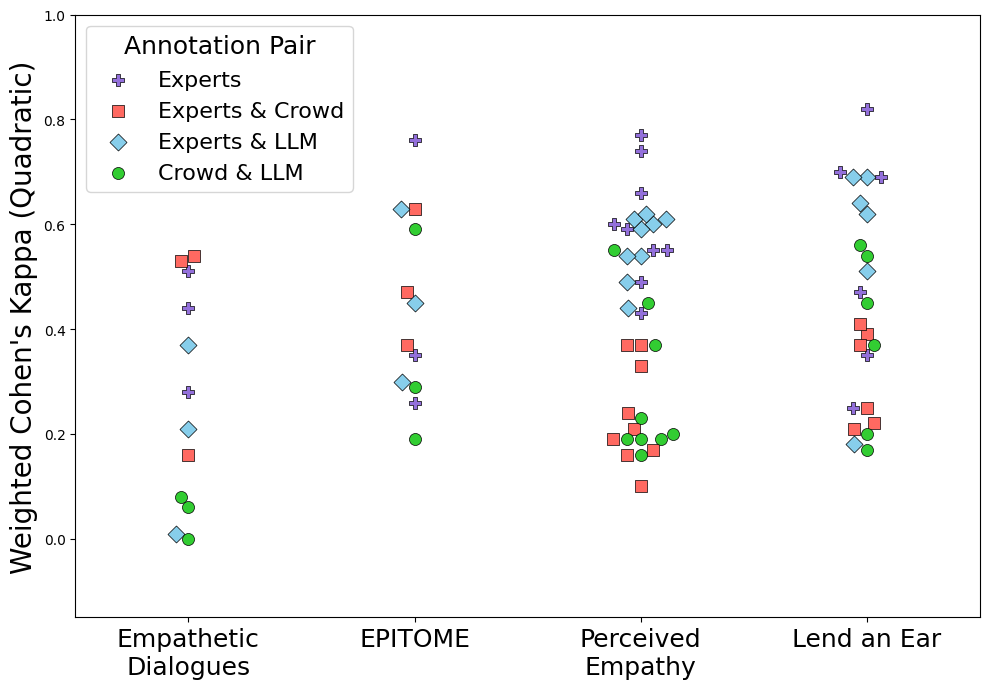

In [9]:
kappa = pd.read_csv("data/all_annotator_pairs_spearman_kappa.csv")

kappa = kappa[
    (kappa["Annotator Pair"] != "('experts', 'gemini')")
    & (kappa["Annotator Pair"] != "('gemini', 'crowd')")
][
    [
        "Dataset",
        "Dimension",
        "Annotator Pair",
        "Weighted Cohen's Kappa",
    ]
]
# Clean up the Annotator Pair labels first
label_mapping = {
    "('expert1', 'expert2')": "Experts",
    "('experts', 'crowd')": "Experts & Crowd",
    "('experts', 'llm')": "Experts & LLM",
    "('llm', 'crowd')": "Crowd & LLM",
}

# Create a clean copy of the data with fixed labels
plot_data = kappa.copy()
plot_data["Annotator Pair"] = plot_data["Annotator Pair"].replace(label_mapping)
plot_data["Weighted Cohen's Kappa"] = plot_data["Weighted Cohen's Kappa"].astype(float)

# Define marker mapping and colors
marker_mapping = {
    "Experts": "P",           # plus filled
    "Experts & Crowd": "s",   # square 
    "Experts & LLM": "D",     # diamond
    "Crowd & LLM": "o",       # circle
}

colors = {
    "Experts": "#9370DB",         # Purple
    "Experts & Crowd": "#FF6961", # Red
    "Experts & LLM": "#87CEEB",   # Light Blue
    "Crowd & LLM": "#32CD32"      # Green
}

hue_order = ["Experts", "Experts & Crowd", "Experts & LLM", "Crowd & LLM"]
dataset_order = ["Empathetic Dialogues", "EPITOME", "Perceived Empathy", "RPG"]

plt.figure(figsize=(10, 7))
ax = sns.swarmplot(
    data=plot_data,
    x="Dataset",
    y="Weighted Cohen's Kappa",
    hue="Annotator Pair",
    hue_order=hue_order,
    order=dataset_order,
    palette=colors,
    size=10
)

# Get the positions from the swarmplot
points_by_hue = {hue: [] for hue in hue_order}

# For each dataset's collection
for dataset_idx, collection in enumerate(ax.collections):
    positions = collection.get_offsets().data
    points_per_hue = len(positions) // len(hue_order)
    
    # Split the positions among the hue values
    for hue_idx, hue in enumerate(hue_order):
        start_idx = hue_idx * points_per_hue
        end_idx = start_idx + points_per_hue
        hue_positions = positions[start_idx:end_idx]
        points_by_hue[hue].append(hue_positions)

plt.close()

# Create final plot
fig, ax = plt.subplots(figsize=(10, 7))

# Plot each hue's points with the correct marker and color
for hue in hue_order:
    all_positions = np.vstack(points_by_hue[hue])
    ax.scatter(
        all_positions[:, 0],
        all_positions[:, 1],
        marker=marker_mapping[hue],
        c=colors[hue],
        s=75,
        edgecolor='black',
        linewidth=0.5,
        label=hue
    )
# Customize plot
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(
    ["Empathetic\nDialogues", "EPITOME", "Perceived\nEmpathy", "Lend an Ear"],
    fontsize=18
)

plt.xlabel("")
plt.ylabel("Weighted Cohen's Kappa (Quadratic)", fontsize=20)

# Handle legend to avoid duplicates
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(
    by_label.values(),
    by_label.keys(),
    title="Annotation Pair",
    loc="upper left",
    frameon=True,
    fontsize=16,
    title_fontsize=18
)

plt.xlim(-0.5, 3.5)
plt.ylim(-0.15, 1)
plt.tight_layout()

plt.savefig("figs/beeswarm_plot_quadratic_cohens_kappa.png", dpi=300, bbox_inches="tight")
plt.show()

In [10]:
###BAR PLOT OF SPEARMAN CORRELATION; APPENDIX FIGURE 1
def plot_gbars_with_ci(df, filename, dimensions):
    # Define labels for different annotator pair comparisons
    comparison_labels = {
        "('expert1', 'expert2')": "E1 vs. E2",
        "('experts', 'crowd')": "E vs. Crowd",
        "('experts', 'llm')": "E vs. LLM",
        "('llm', 'crowd')": "LLM vs. Crowd",
    }

    # Initialize dictionaries to store correlation values and confidence intervals for each comparison
    correlations = {comp: [] for comp in comparison_labels}
    confidence_intervals = {comp: [] for comp in comparison_labels}

    # Iterate over each comparison to extract relevant data from the DataFrame
    for comp in comparison_labels:
        # Filter data for the current annotator pair
        comp_data = df[df["Annotator Pair"] == comp]
        for dim in dimensions:
            # Filter data for the current dimension
            dim_data = comp_data[comp_data["Dimension"] == dim]
            # Append the Spearman Correlation value to the list
            correlations[comp].append(dim_data["Spearman Correlation"].values[0])
            # Calculate and append the confidence interval error
            ci_lower = dim_data["Fisher CI Lower"].values[0]
            ci_upper = dim_data["Fisher CI Upper"].values[0]
            confidence_intervals[comp].append(
                (ci_upper - ci_lower) / 2
            )  # Error is half the CI range

    # Create a figure and axis for the bar plot
    fig, ax = plt.subplots(figsize=(26, 7))

    # Define x positions for the bars
    x = np.arange(len(comparison_labels))

    # Format dimension labels for better readability
    dimension_labels = [
        dim.replace("m_", "").replace("level_", "").replace("_", "\n").title()
        for dim in dimensions
    ]

    colors = [
        "#8B008B",
        "#FA8072",
        "#FFA500",
        "#FFD700",
        "#40E0D0",
        "#1E90FF",
        "#2E8B57",
        "#BA55D3",
        "#708090",
    ]

    width = 0.1
    n_dims = len(dimensions)

    offsets = np.linspace(-(n_dims - 1) / 2.0, (n_dims - 1) / 2.0, n_dims)
    offsets *= width

    for i, dim in enumerate(dimensions):
        dim_correlation = [correlations[comp][i] for comp in comparison_labels]
        dim_ci = [confidence_intervals[comp][i] for comp in comparison_labels]

        # Plot the bar for the current dimension
        ax.bar(
            x + offsets[i],
            dim_correlation,
            width,
            yerr=dim_ci,
            label=dimension_labels[i],
            color=colors[i % len(colors)],
            capsize=5,  # Add caps to the error bars
        )

    ax.set_xticks(x)
    ax.set_xticklabels(
        ["E1 vs E2", "E vs Crowd", "E vs LLM", "LLM vs Crowd"], fontsize=16
    )
    ax.set_ylabel("Spearman Correlation", fontsize=20)
    ax.set_ylim(-0.5, 1.0)  # Set y-axis limits
    plt.xlim(-1, len(comparison_labels))  # Set x-axis limits

    ax.tick_params(axis="x", which="major", length=8, width=2, labelsize=20)
    ax.tick_params(axis="y", which="major", length=8, width=2, labelsize=20)

    # Add a legend to the plot
    ax.legend(
        loc="upper left",
        frameon=True,
        fontsize=20,
        title="Dimensions",
        title_fontsize=20,
    )

    plt.tight_layout()
    plt.ylim(-0.35, 1.0)
    plt.savefig(filename, dpi=300)
    plt.show()


df = pd.read_csv("data/all_annotator_pairs_spearman_kappa.csv")
df["Annotator Pair"] = df["Annotator Pair"].astype(str)

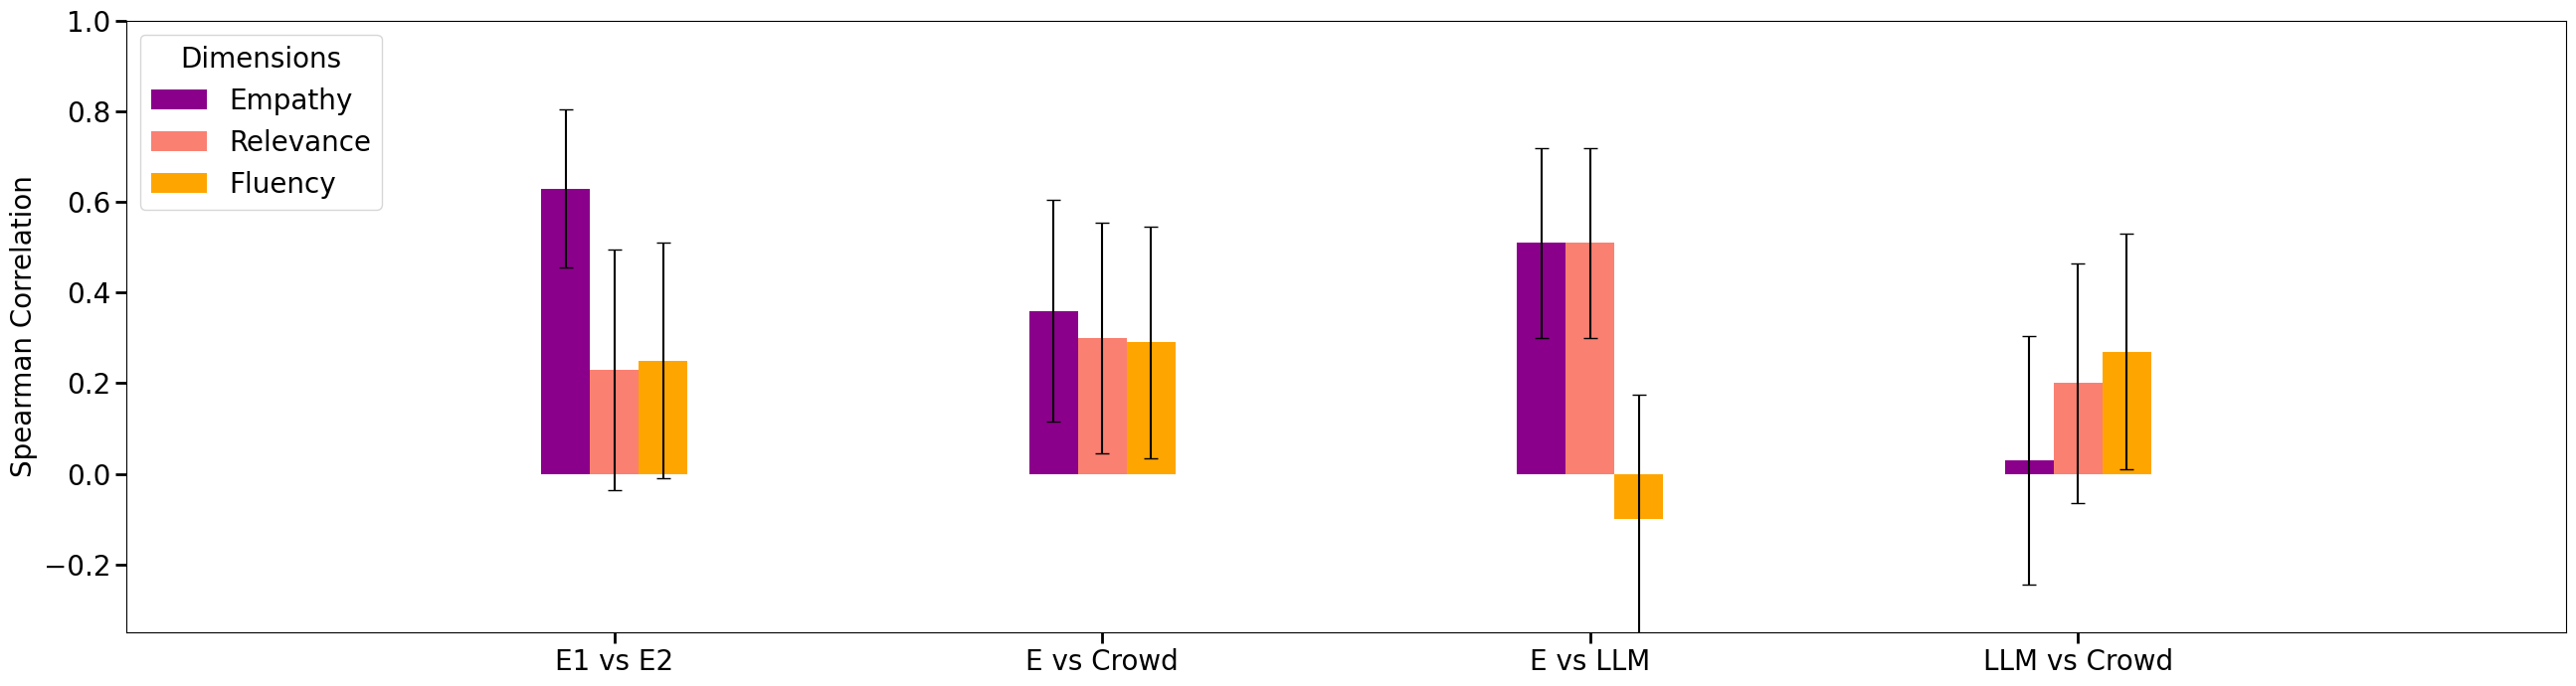

In [11]:
dimensions = ["empathy", "relevance", "fluency"]
plot_gbars_with_ci(df, "figs/empatheticdialogues_spearman.png", dimensions)

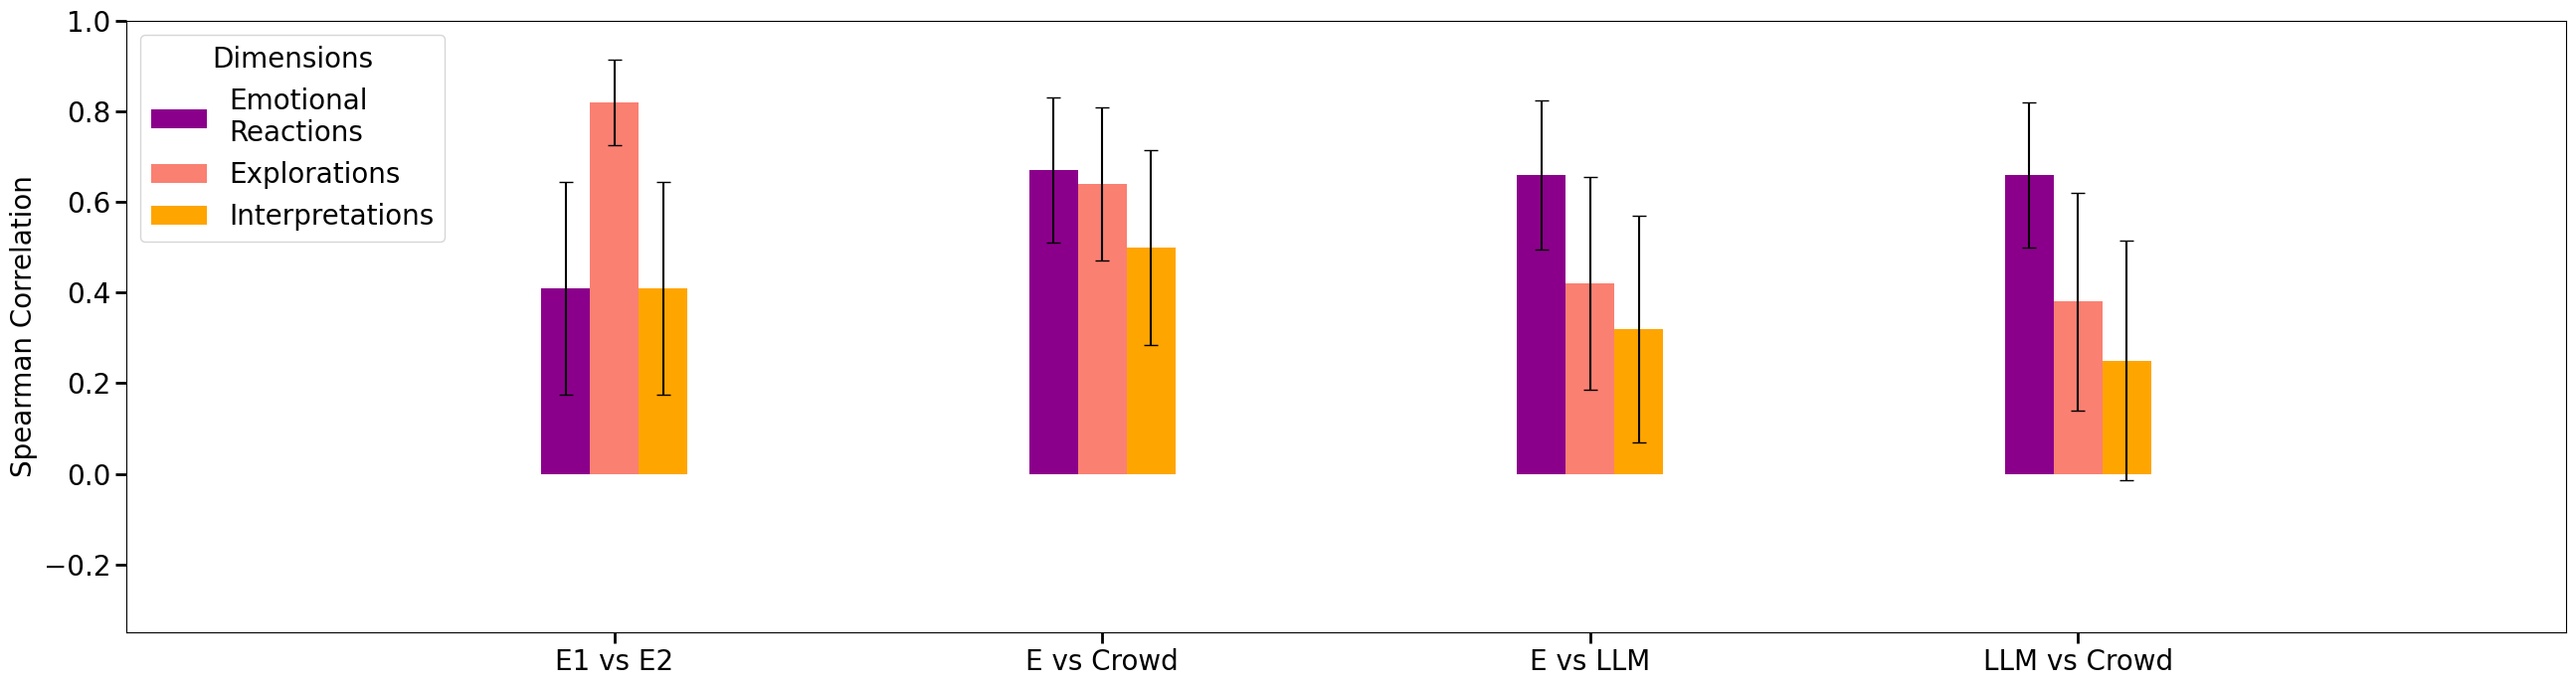

In [12]:
dimensions = [
    "level_emotional_reactions",
    "level_explorations",
    "level_interpretations",
]
plot_gbars_with_ci(df, "figs/epitome_spearman.png", dimensions)

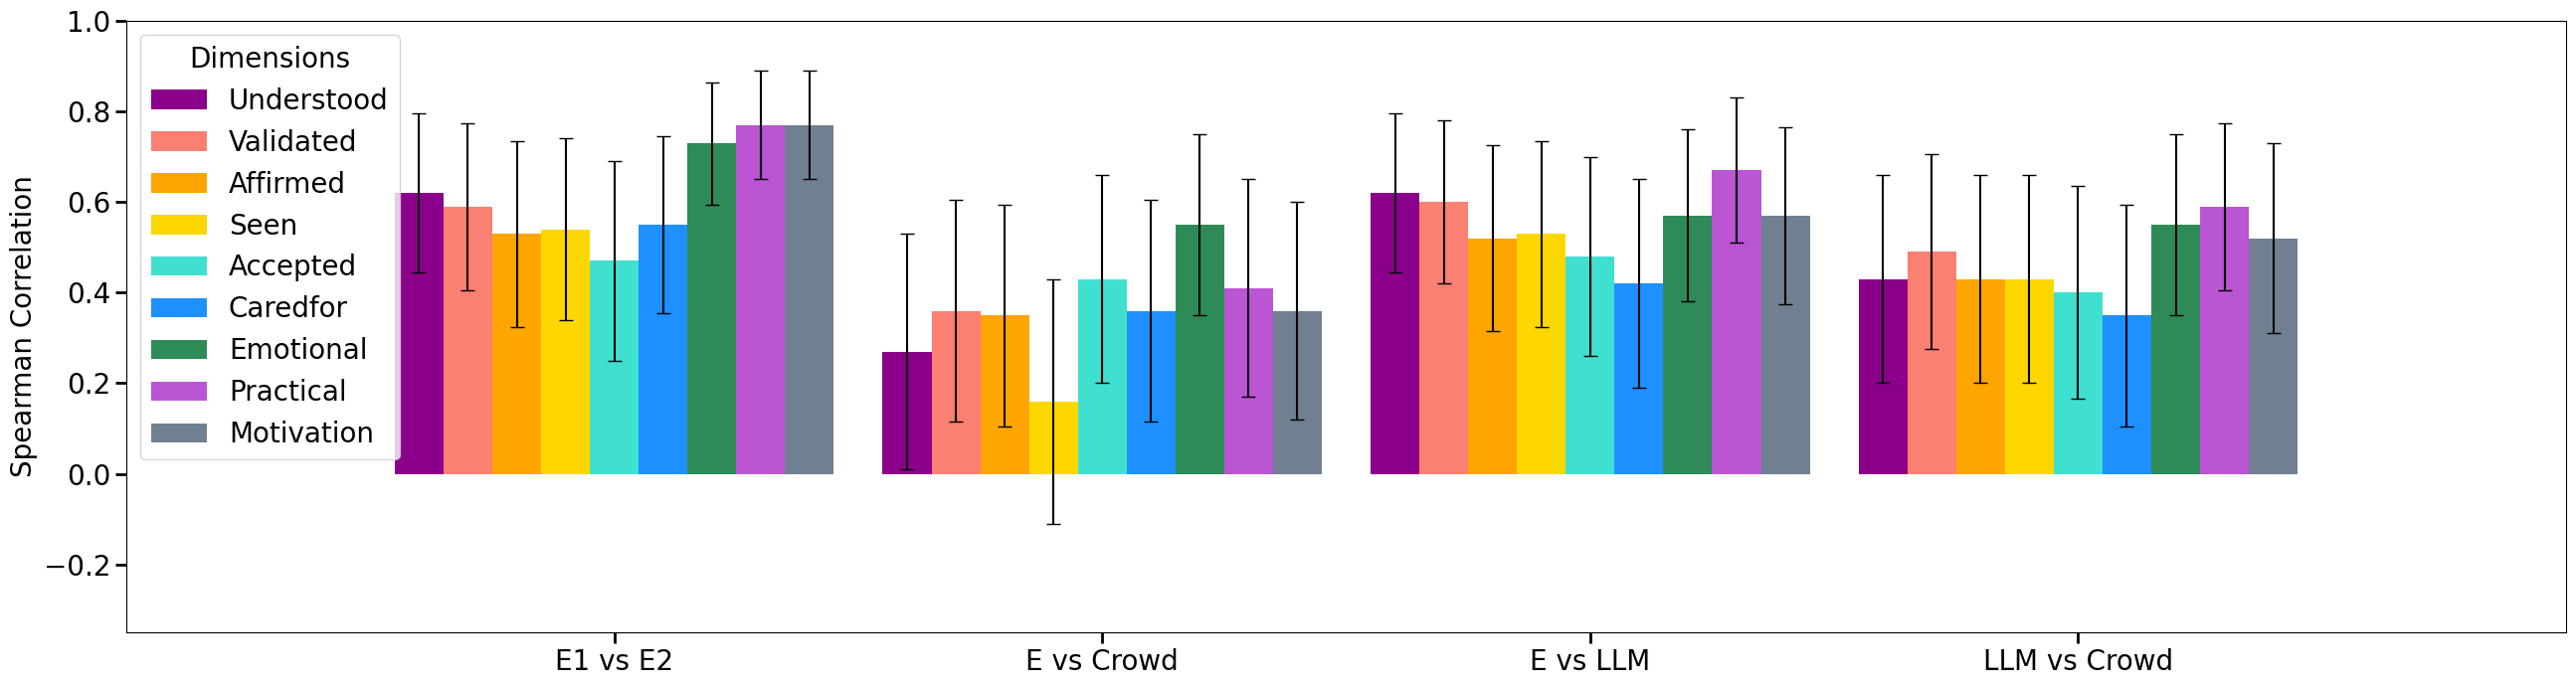

In [13]:
dimensions = [
    "m_understood",
    "m_validated",
    "m_affirmed",
    "m_seen",
    "m_accepted",
    "m_caredfor",
    "m_emotional",
    "m_practical",
    "m_motivation",
]
plot_gbars_with_ci(df, "figs/perceived_empathy_spearman.png", dimensions)

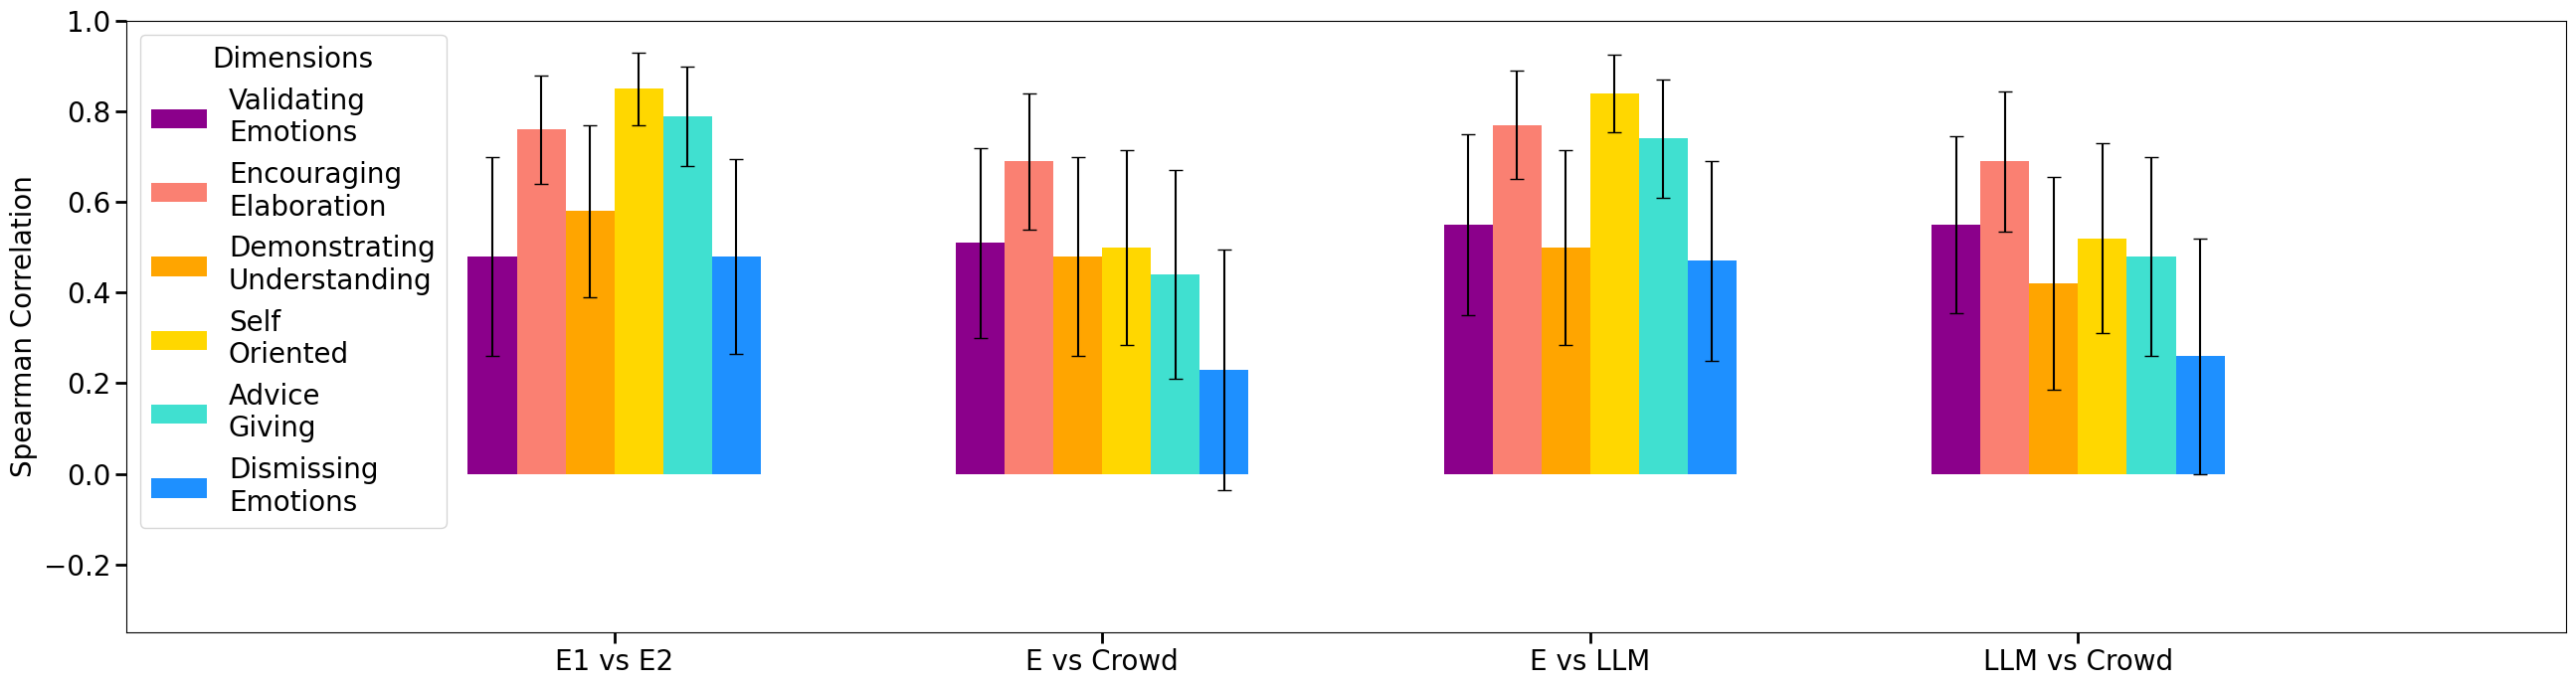

In [14]:
dimensions = [
    "validating_emotions",
    "encouraging_elaboration",
    "demonstrating_understanding",
    "self_oriented",
    "advice_giving",
    "dismissing_emotions",
]

plot_gbars_with_ci(df, "figs/lendanear_spearman.png", dimensions)

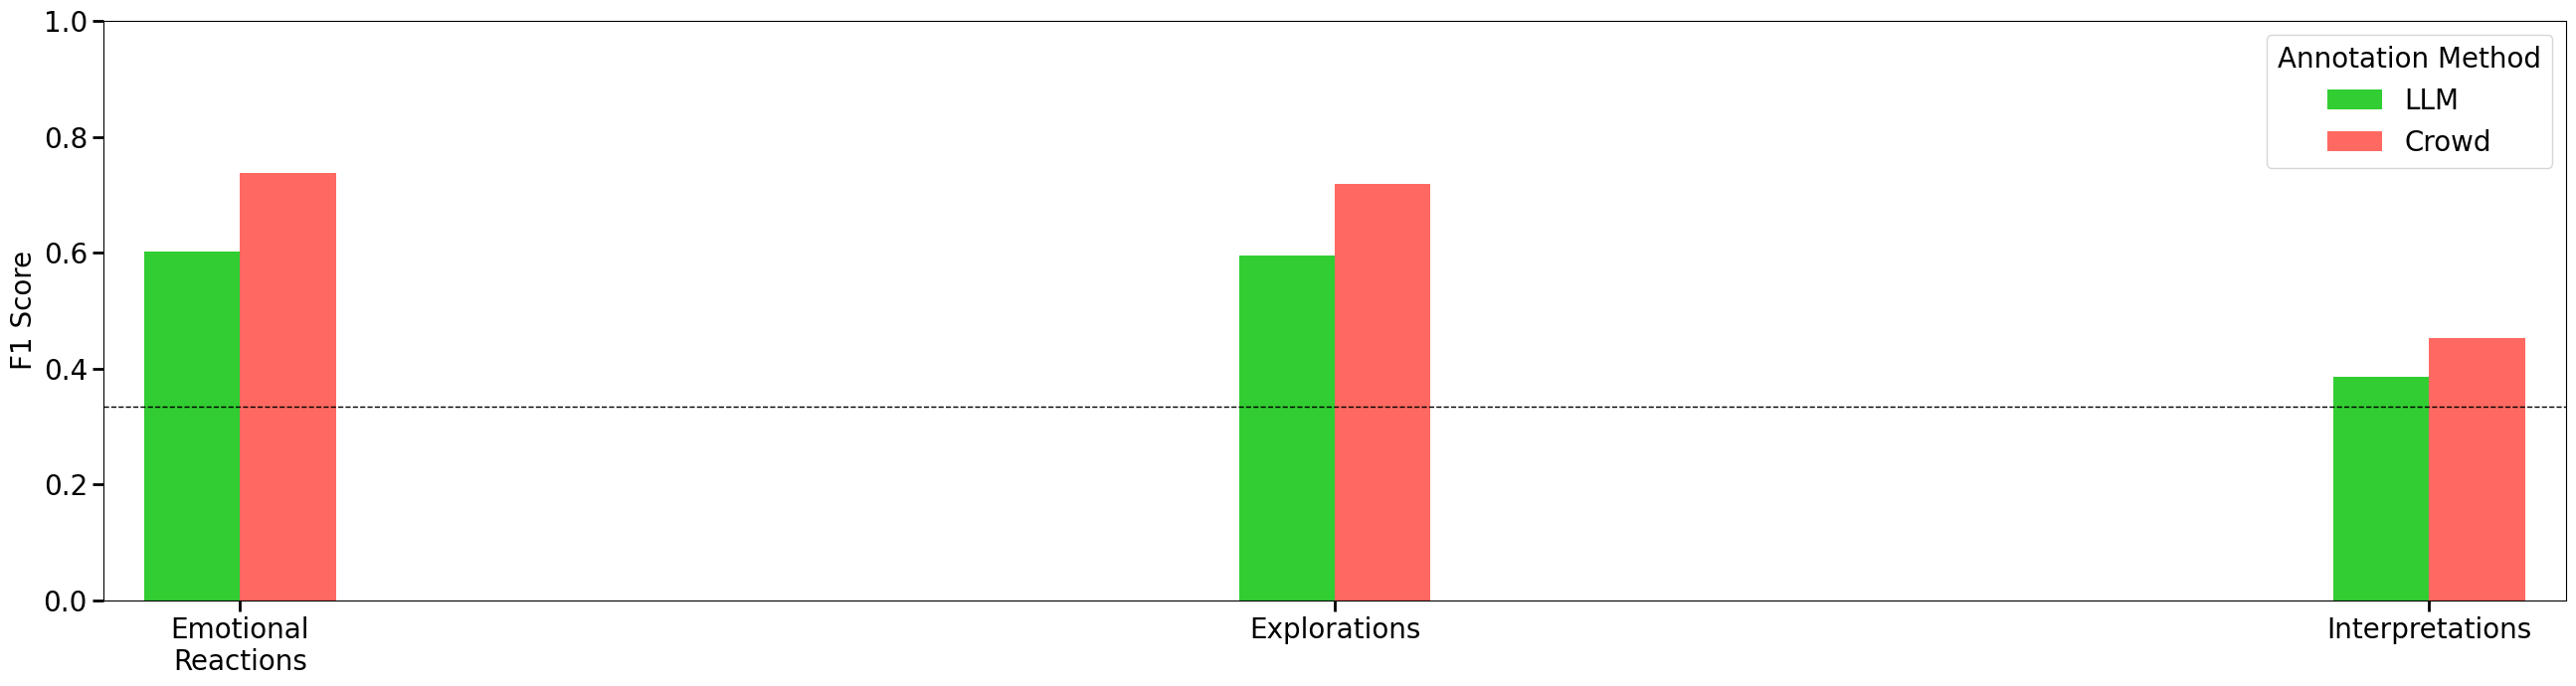

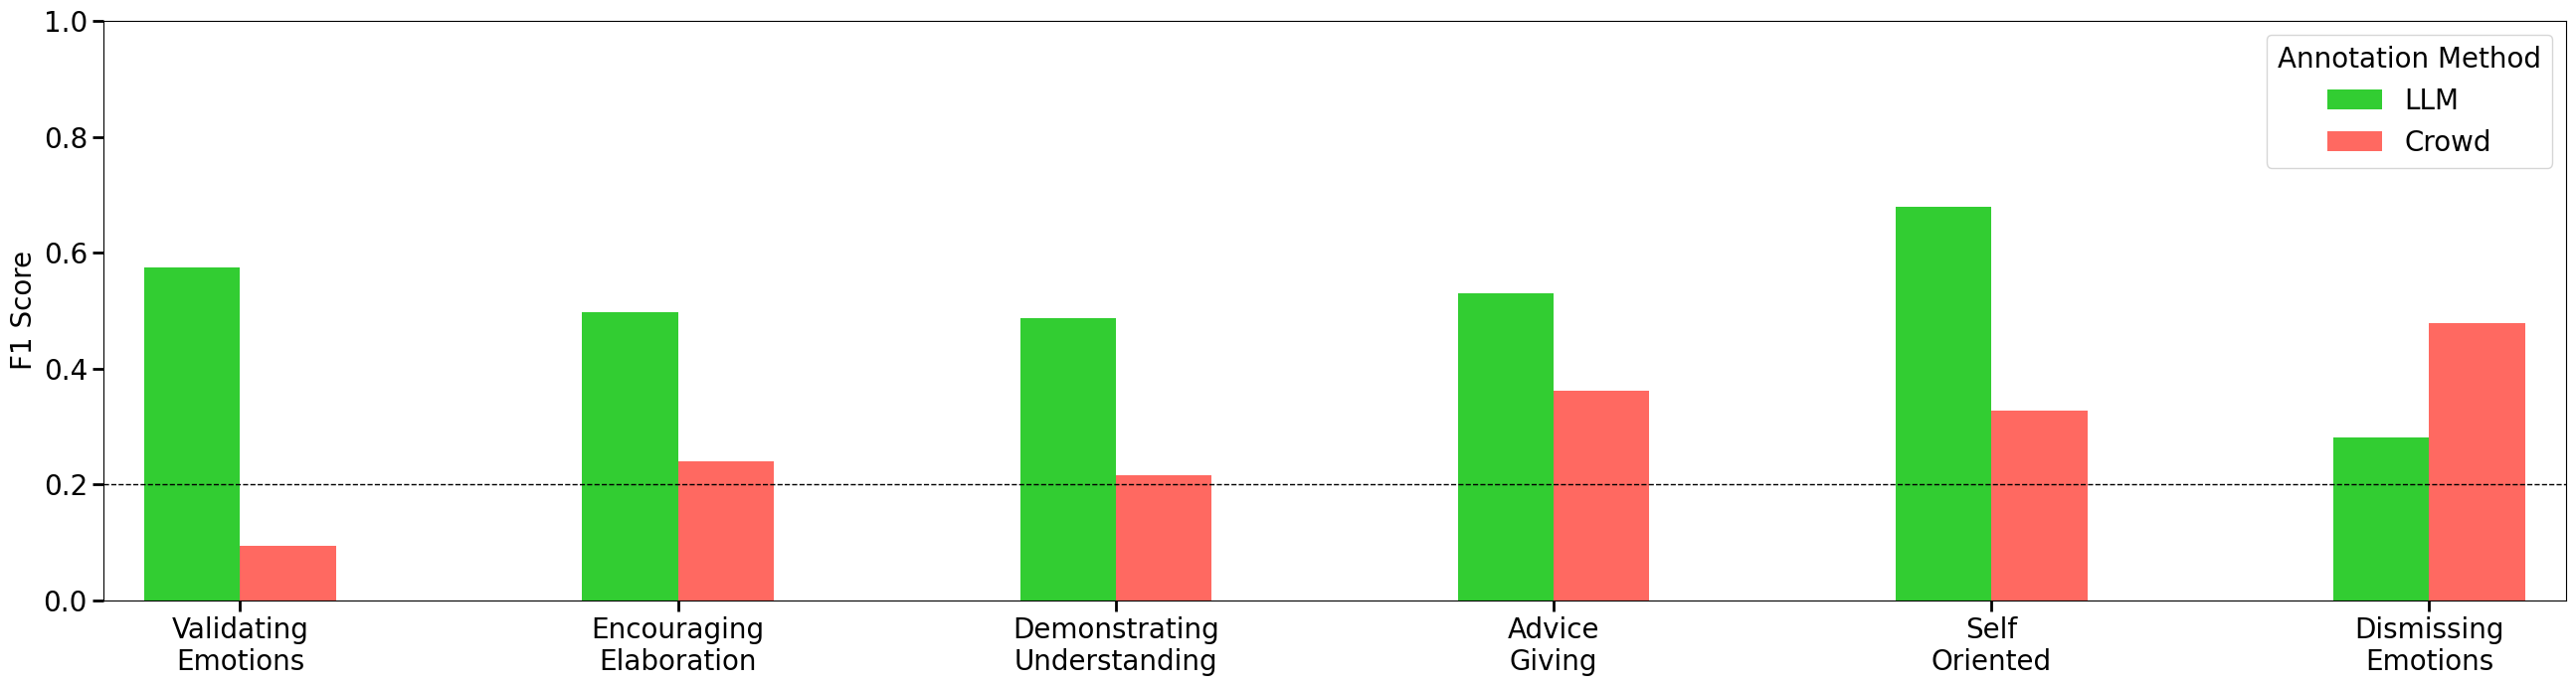

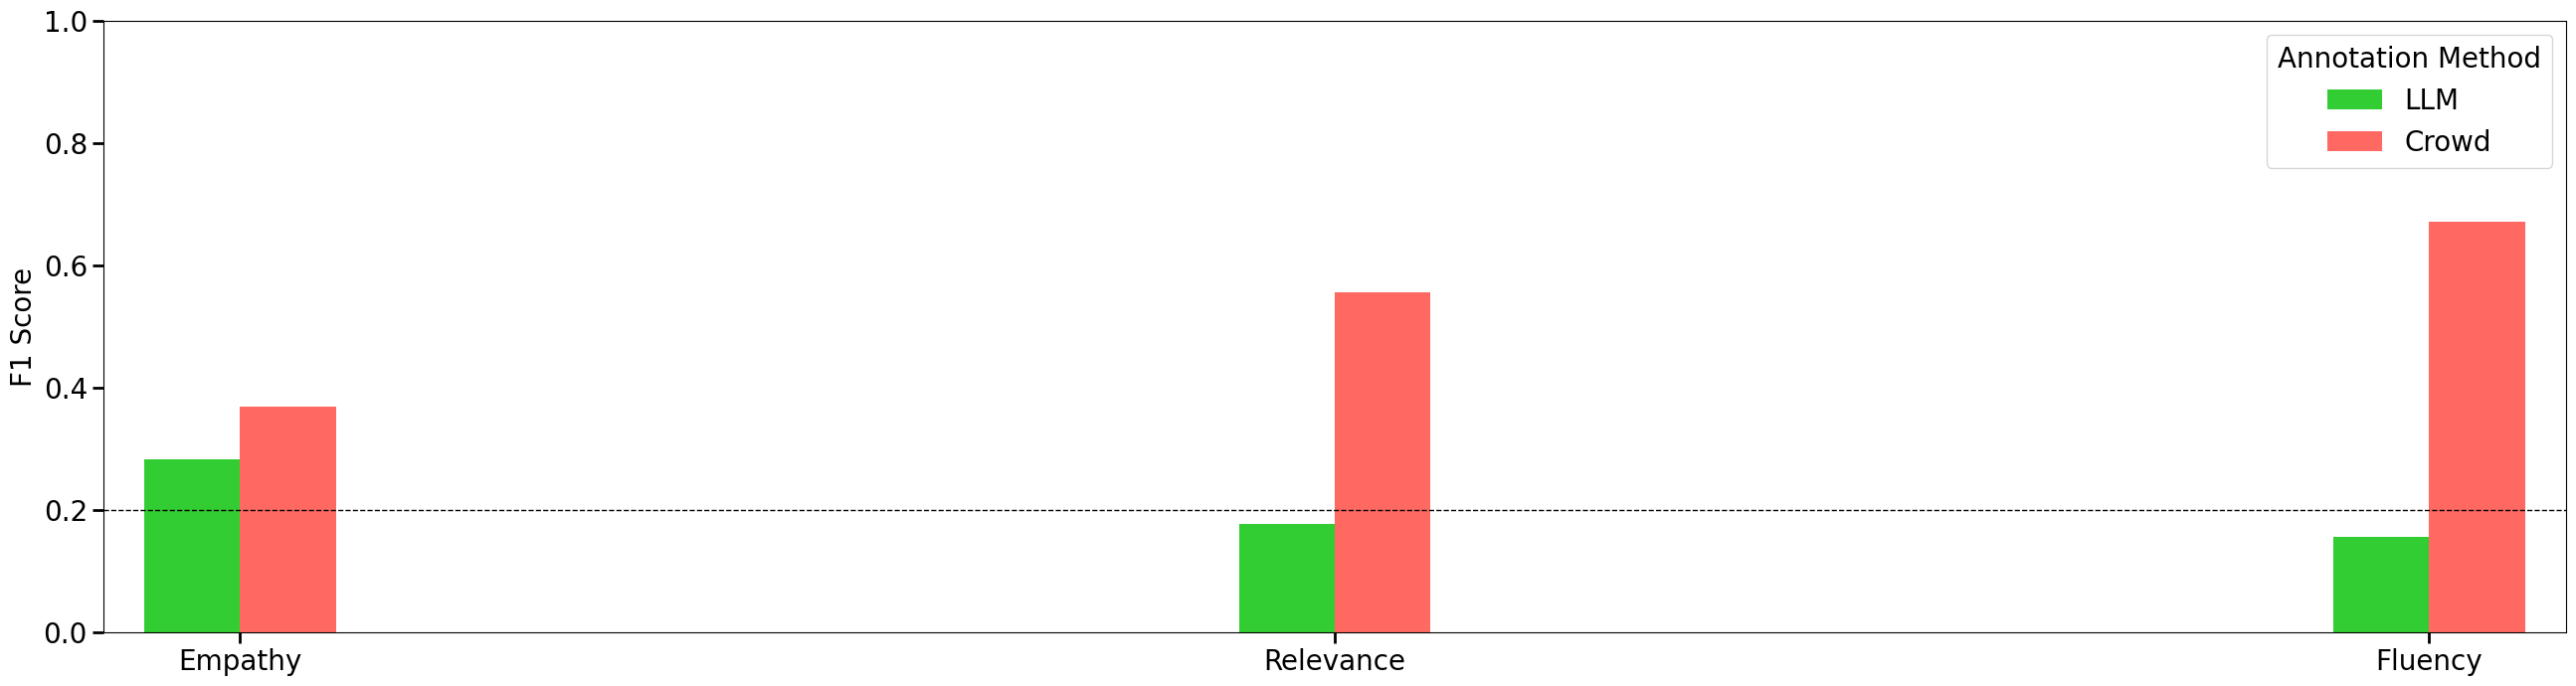

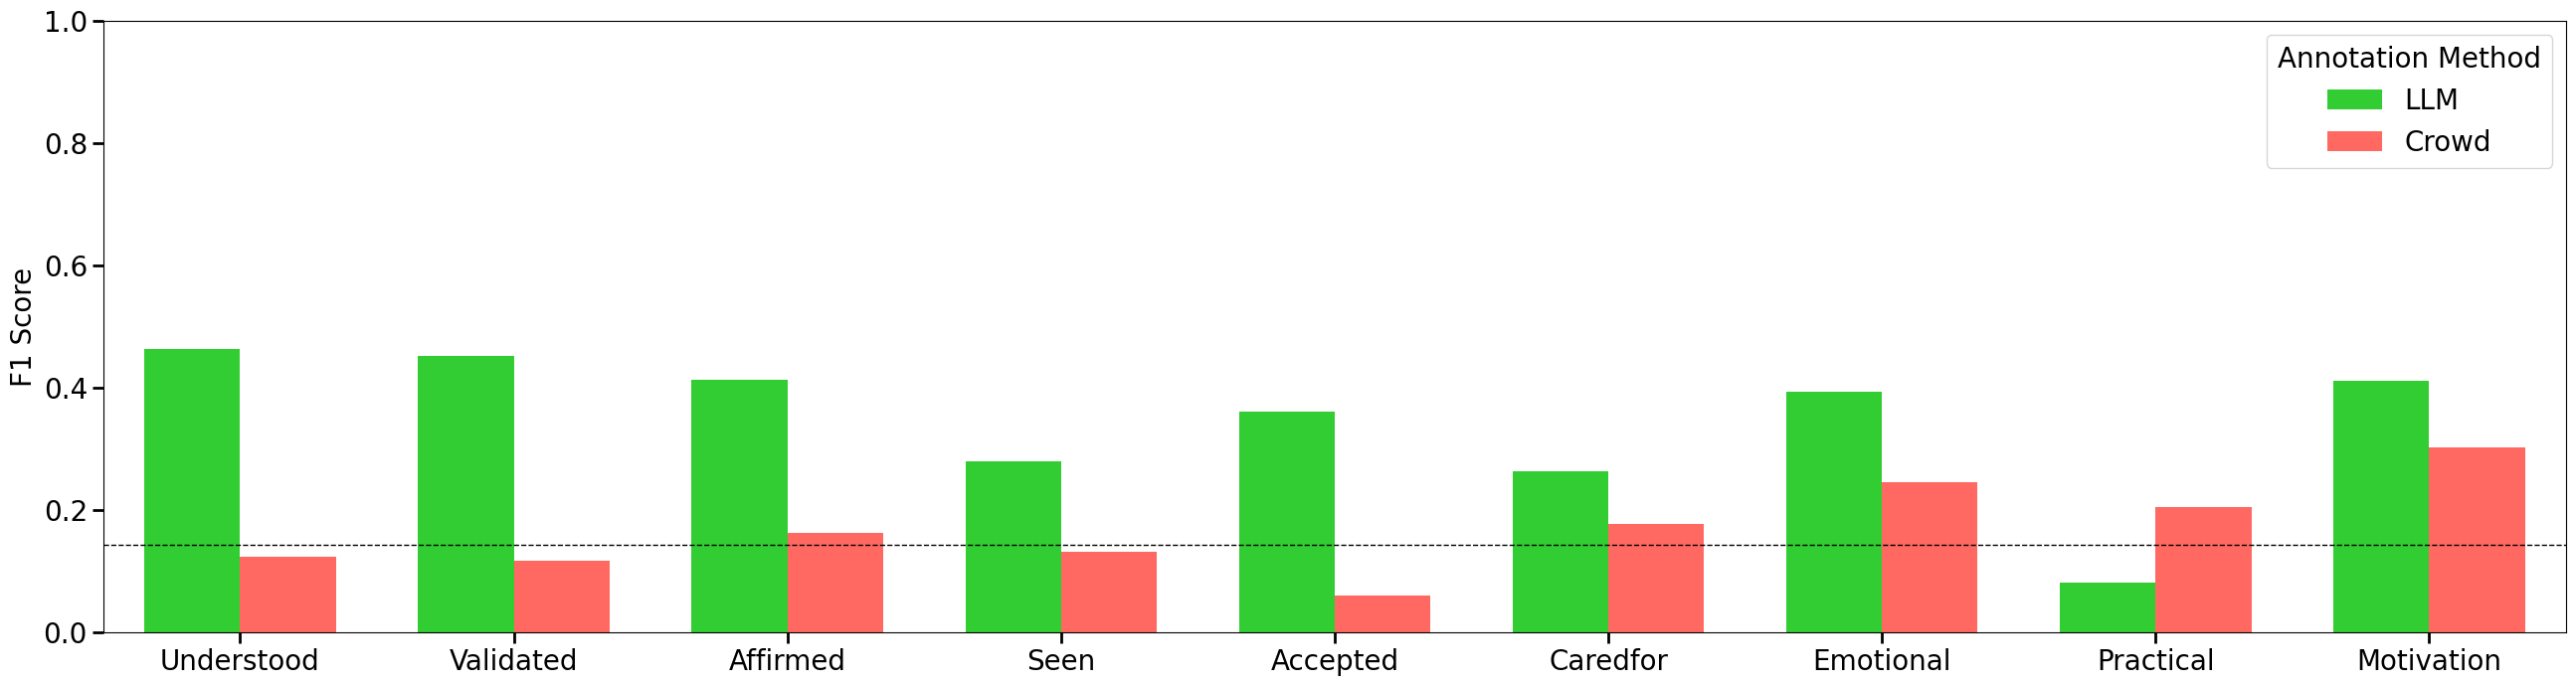

In [15]:
### F1 SCORES; APPENDIX FIGURE 
df = pd.read_csv("data/combined_annotations_across_methods_and_datasets.csv")

# Function to calculate F1 scores for each dimension within a dataset
def calculate_f1_scores(df, dimensions, method):
    scores = {}  
    for dim in dimensions:
        expert_ratings = df[df['annotation_method'] == 'experts'][dim].round(0)
        method_ratings = df[df['annotation_method'] == method][dim].round(0)
        
        # Calculate the weighted F1 score between expert and method ratings
        f1 = f1_score(expert_ratings, method_ratings, average='weighted')
        scores[dim] = {'F1 Score': f1}
    return scores  

# Dictionary to store F1 scores for each dataset and method
f1_scores = {
    'epitome': {
        'scores': {
            'llm': calculate_f1_scores(df, datasets['epitome']['dimensions'], 'llm'),
            'crowd': calculate_f1_scores(df, datasets['epitome']['dimensions'], 'crowd')
        }
    },
    'rpg': {
        'scores': {
            'llm': calculate_f1_scores(df, datasets['rpg']['dimensions'], 'llm'),
            'crowd': calculate_f1_scores(df, datasets['rpg']['dimensions'], 'crowd')
        }
    },
    'empatheticdialogues': {
        'scores': {
            'llm': calculate_f1_scores(df, datasets['empatheticdialogues']['dimensions'], 'llm'),
            'crowd': calculate_f1_scores(df, datasets['empatheticdialogues']['dimensions'], 'crowd')
        }
    },
    'perceived_empathy': {
        'scores': {
            'llm': calculate_f1_scores(df, datasets['perceived_empathy']['dimensions'], 'llm'),
            'crowd': calculate_f1_scores(df, datasets['perceived_empathy']['dimensions'], 'crowd')
        }
    }
}

# Function to plot F1 scores for each dataset
def plot_f1_scores(llm_scores, crowd_scores, title, max_dims=9):
    dimensions = list(llm_scores.keys())
    llm_f1 = [llm_scores[dim]['F1 Score'] for dim in dimensions]
    crowd_f1 = [crowd_scores[dim]['F1 Score'] for dim in dimensions]

    methods = ['LLM', 'Crowd']
    scores = [llm_f1, crowd_f1]

    n_dims = len(dimensions)
    n_methods = len(methods)

    fig, ax = plt.subplots(figsize=(26, 7))

    dimension_labels = [
        dim.replace('m_', '')
           .replace('level_', '')
           .replace('_', '\n')
           .title()
        for dim in dimensions
    ]

    x = np.linspace(0, max_dims - 1, n_dims)

    width = 0.35

    offsets = np.linspace(-(n_methods - 1) / 2.0, (n_methods - 1) / 2.0, n_methods) * width

    colors = ['#32CD32', '#FF6961']
    for i, (method, method_scores) in enumerate(zip(methods, scores)):
        ax.bar(
            x + offsets[i],
            method_scores,
            width,
            label=method,
            color=colors[i]
        )

    # Random guess thresholds for each dataset
    thresholds = {
        'F1 Scores for Epitome': 1/3,
        'F1 Scores for RPG': 1/5,
        'F1 Scores for Empathetic Dialogues': 1/5,
        'F1 Scores for Perceived Empathy': 1/7
    }
    if title in thresholds:
        ax.axhline(y=thresholds[title], color='black', linestyle='--', linewidth=1)

    # Axis labeling
    ax.set_ylabel('F1 Score', fontsize=20)
    ax.set_xticks(x)
    ax.set_xticklabels(dimension_labels, fontsize=20)
    ax.tick_params(axis='x', which='major', length=8, width=2, labelsize=20)
    ax.tick_params(axis='y', which='major', length=8, width=2, labelsize=20)
    ax.set_ylim(0, 1.0)

    ax.set_xlim(-0.5, max_dims - 0.5)

    ax.legend(loc='upper right', frameon=True, fontsize=20,
              title='Annotation Method', title_fontsize=20)

    plt.tight_layout()
    plt.savefig(f"figs/{title.replace(' ', '_')}_f1_scores.png", dpi=300)
    plt.show()


# Plot F1 scores for each dataset
plot_f1_scores(
    f1_scores['epitome']['scores']['llm'], 
    f1_scores['epitome']['scores']['crowd'], 
    'F1 Scores for Epitome'
)

plot_f1_scores(
    f1_scores['rpg']['scores']['llm'], 
    f1_scores['rpg']['scores']['crowd'], 
    'F1 Scores for RPG'
)

plot_f1_scores(
    f1_scores['empatheticdialogues']['scores']['llm'], 
    f1_scores['empatheticdialogues']['scores']['crowd'], 
    'F1 Scores for Empathetic Dialogues'
)

plot_f1_scores(
    f1_scores['perceived_empathy']['scores']['llm'], 
    f1_scores['perceived_empathy']['scores']['crowd'], 
    'F1 Scores for Perceived Empathy'
)

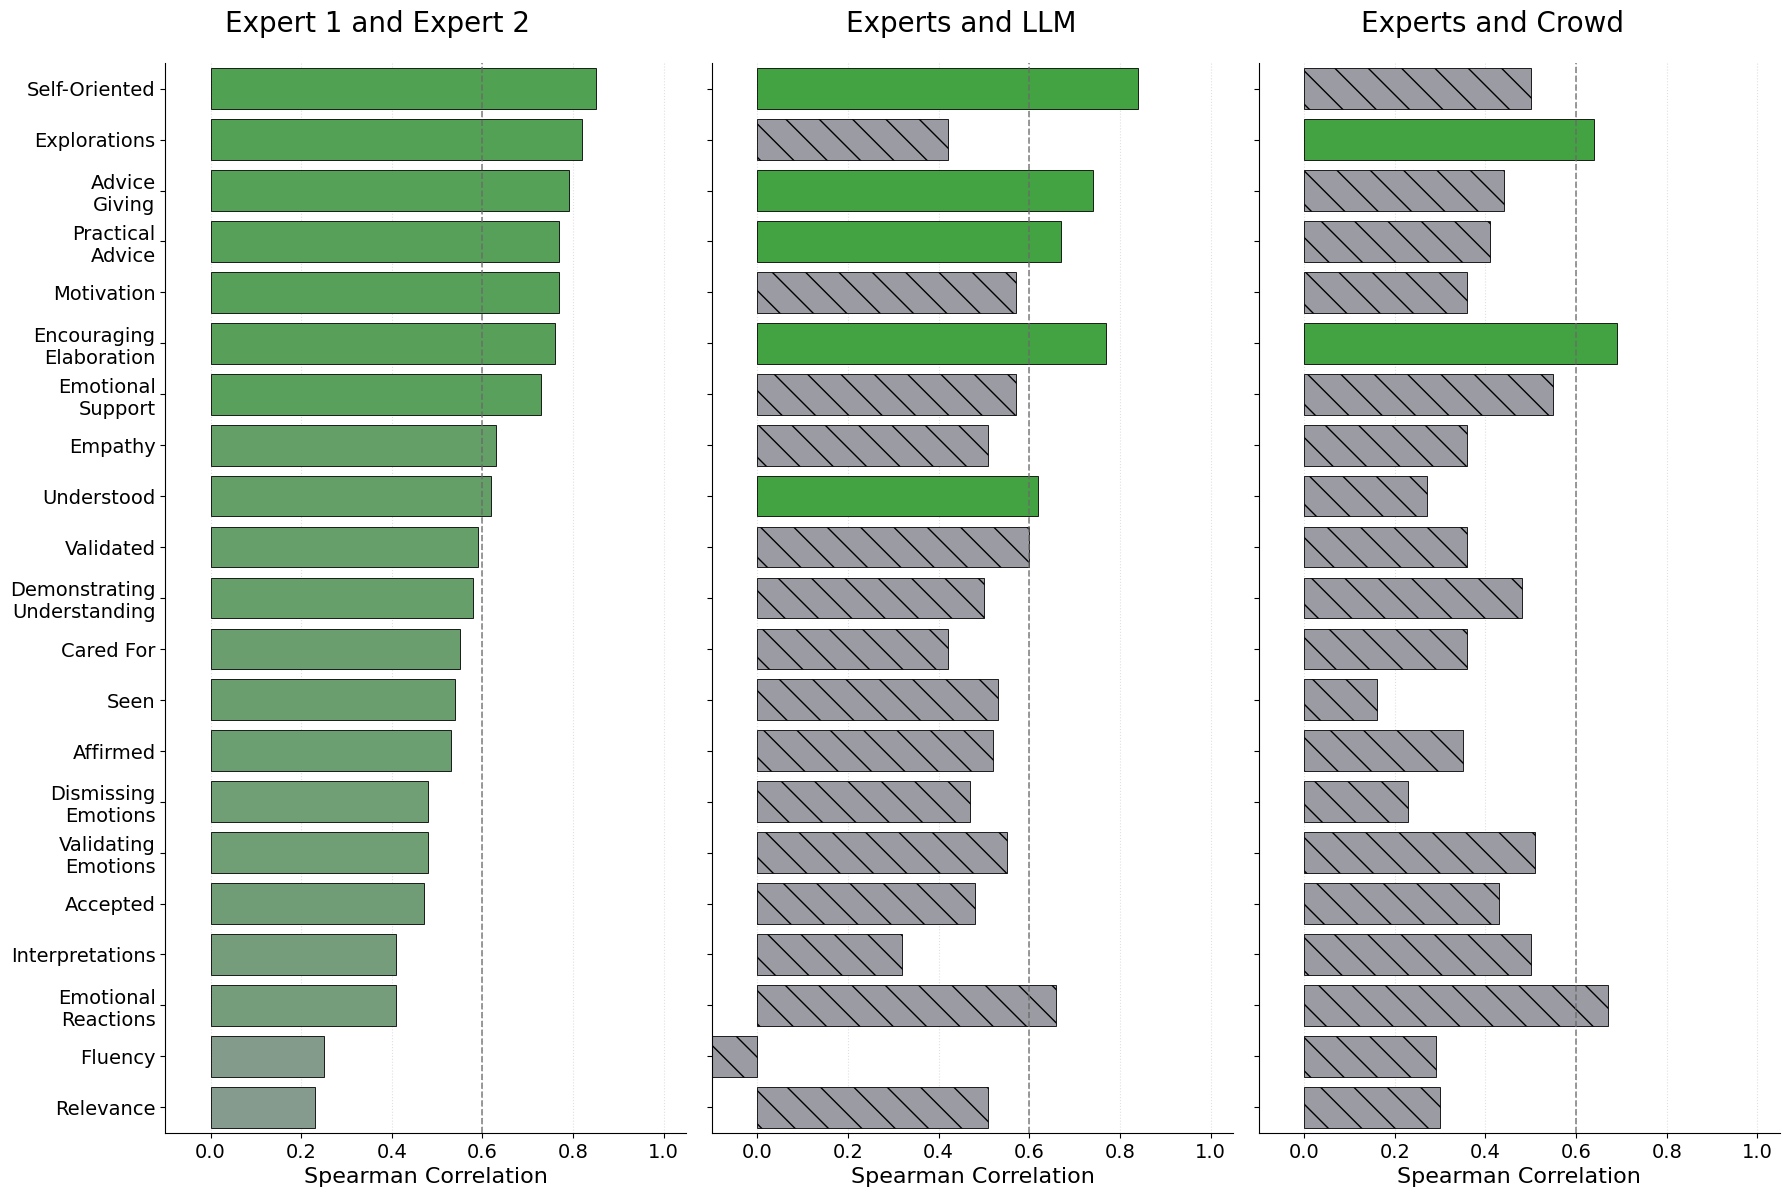

In [34]:
#CONTINUUM OF RELIABILITY
df = pd.read_csv("data/table_3.csv") 

dimension_map = {
    'relevance': 'Relevance', 'fluency': 'Fluency', 'level_interpretations': 'Interpretations',
    'level_emotional_reactions': 'Emotional\nReactions', 'm_accepted': 'Accepted',
    'validating_emotions': 'Validating\nEmotions', 'dismissing_emotions': 'Dismissing\nEmotions',
    'm_affirmed': 'Affirmed', 'm_seen': 'Seen', 'm_caredfor': 'Cared For',
    'demonstrating_understanding': 'Demonstrating\nUnderstanding', 'm_validated': 'Validated',
    'm_understood': 'Understood', 'empathy': 'Empathy', 'm_emotional': 'Emotional\nSupport',
    'encouraging_elaboration': 'Encouraging\nElaboration', 'm_motivation': 'Motivation',
    'm_practical': 'Practical\nAdvice', 'advice_giving': 'Advice\nGiving',
    'level_explorations': 'Explorations', 'self_oriented': 'Self-Oriented'
}
df['Dimension'] = df['Dimension'].replace(dimension_map)

pair_map = {
    "('expert1', 'expert2')": "Expert 1 and Expert 2", "('experts', 'llm')": "Experts and LLM",
    "('experts', 'crowd')": "Experts and Crowd", "('llm', 'crowd')": "LLM and Crowd"
}
df['Annotator Pair'] = df['Annotator Pair'].replace(pair_map)

expert_pair_filter = df['Annotator Pair'] == "Expert 1 and Expert 2"

expert_data = df.loc[expert_pair_filter, ['Dimension', 'Spearman Correlation']].copy()
expert_data['rank'] = expert_data['Spearman Correlation'].rank(method='min', ascending=False).astype(int)
expert_data = expert_data.sort_values('rank')
expert_corr_map = expert_data.set_index('Dimension')['Spearman Correlation']

rank_calc_df = df.loc[expert_pair_filter, ['Dimension', 'Spearman Correlation']].copy()
rank_calc_df['rank'] = rank_calc_df['Spearman Correlation'].rank(method='min', ascending=False).astype(int)
rank_calc_df = rank_calc_df.sort_values('rank')
df = df.merge(rank_calc_df[['Dimension', 'rank']], on='Dimension', how='left')

gray_start_color = np.array([0.6, 0.6, 0.65]) 
green_end_color = np.array([0.2, 0.7, 0.2])   

comparison_gray_color = (0.6, 0.6, 0.65)
comparison_green_color = (0.2, 0.7, 0.2)
correlation_threshold = 0.6 
hatch_pattern = '\\' 
fig, axes = plt.subplots(1, 3, figsize=(18, 12), sharey=True) 

pairs_to_plot = ["Expert 1 and Expert 2", "Experts and LLM", "Experts and Crowd"]

for i, pair in enumerate(pairs_to_plot):
    ax = axes[i]
    pair_data = df[df['Annotator Pair'] == pair].copy()
    pair_data = pair_data.sort_values('rank', ascending=True)

    plot_colors = []
    plot_hatches = []

    if pair == "Expert 1 and Expert 2":
        correlations = pair_data['Spearman Correlation']
        min_corr = 0
        max_corr = 1
        norm_corrs = np.clip((correlations - min_corr) / (max_corr - min_corr), 0, 1)

        for norm_corr in norm_corrs:
            interpolated_color = gray_start_color * (1 - norm_corr) + green_end_color * norm_corr
            plot_colors.append(tuple(interpolated_color))
        plot_hatches = [None] * len(pair_data)

        sns.barplot(ax=ax, y='Dimension', x='Spearman Correlation', data=pair_data,
                    palette=plot_colors,
                    errorbar=None,
                    edgecolor='black',
                    linewidth=0.6,
                    hue='Dimension',
                    legend=False)

    else:
        for index, row in pair_data.iterrows():
            dimension = row['Dimension']
            expert_corr = expert_corr_map.get(dimension, 0)

            if expert_corr < correlation_threshold:
                plot_colors.append(comparison_gray_color)
                plot_hatches.append(hatch_pattern)
            else:
                correlation = row['Spearman Correlation']
                if correlation >= correlation_threshold:
                    plot_colors.append(comparison_green_color)
                    plot_hatches.append(None)
                else:
                    plot_colors.append(comparison_gray_color)
                    plot_hatches.append(hatch_pattern)

        sns.barplot(ax=ax, y='Dimension', x='Spearman Correlation', data=pair_data,
                    palette=plot_colors,
                    errorbar=None,
                    edgecolor='black',
                    linewidth=0.6,
                    hue='Dimension',
                    legend=False)

    for bar, hatch_type in zip(ax.patches, plot_hatches):
        if hatch_type:
            bar.set_hatch(hatch_type)

    ax.text(.7, 1.05, f'{pair}', transform=ax.transAxes,
            fontsize=20, va='top', ha='right')

    ax.set_xlabel('Spearman Correlation', fontsize=16)
    ax.tick_params(axis='x', labelsize=14)
    ax.set_xlim(-0.1, 1.05)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    if i == 0:
        ax.set_ylabel('', fontsize=16)
        ax.tick_params(axis='y', labelsize=14)
    else:
        ax.set_ylabel('') 

    ax.axvline(x=correlation_threshold, color='dimgrey', linestyle='--', linewidth=1.2, alpha=0.8)

    ax.grid(axis='x', linestyle=':', alpha=0.7, color='lightgrey')
    ax.set_axisbelow(True) 

plt.tight_layout(w_pad=1.5) 
plt.show()
plt.savefig('figs/continuum_of_reliability.png', dpi=300)